<a href="https://colab.research.google.com/github/Qu1nnD/CS290/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Allow for two centroid initialization options: either specify the initial centroids or select them randomly from the dataset being used. Experiment with both options to see how the final centroids depend on the initialization.

When applying your algorithm, plot the data and the current centroids at each iteration. This provides a nice visualization of the algorithm in action.

With both the iris and penguins datasets, you actually have labels and therefore know the correct number of clusters, 𝑘. Experiment with different values of 𝑘 to see what happens, since the “correct” value isn’t actually known in practice.

In [2]:
penguins = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv")

In [3]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


In [71]:
def K_Means(k, dataset):
    features = dataset[['bill_length_mm', 'bill_depth_mm','flipper_length_mm','body_mass_g']].dropna() #
    converged = False #
    centroids=features.sample(n=k).to_numpy() #
    while not converged: # Loops until there isn't massive changes between centroids and new_centroids
        # Fix centroid distance stuff
        distances = np.linalg.norm(features.to_numpy()[:, np.newaxis] - centroids, axis=2) # calcuates the eudclidean distance between data points and centroids
        labels = np.argmin(distances, axis=1) # assigns data points to the closest centroid
        new_centroids = np.array([features[labels == i].mean(axis=0) for i in range(k)]) # calculates updated centroids given the mean of all data points from each cluster
        #Plot Stuff
        plt.figure()
        #Change scatter plot stuff
        plt.scatter(features['flipper_length_mm'], features['bill_length_mm'], c=labels, marker='o') #
        plt.scatter(new_centroids[:, 0], new_centroids[:, 1], c='red',marker='X', s=200) #
        plt.title(f'Current Centroids for k={k}') #
        plt.xlabel('flipper_length_mm') #
        plt.ylabel('Bill Length (mm)') #
        plt.show() #
        #Convergence test
        converged = np.all(centroids == new_centroids) #
        centroids = new_centroids #

    return labels, centroids

Running K-Means with k=3


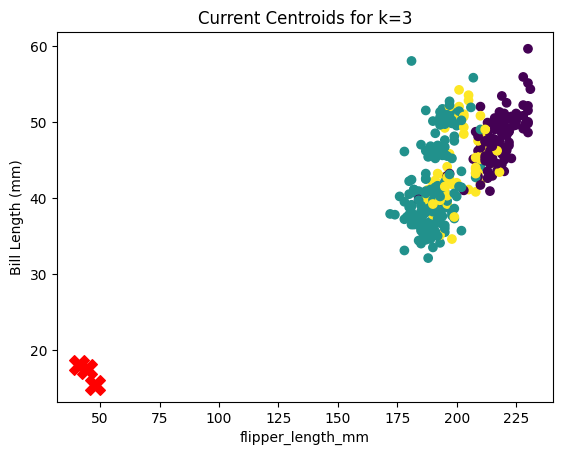

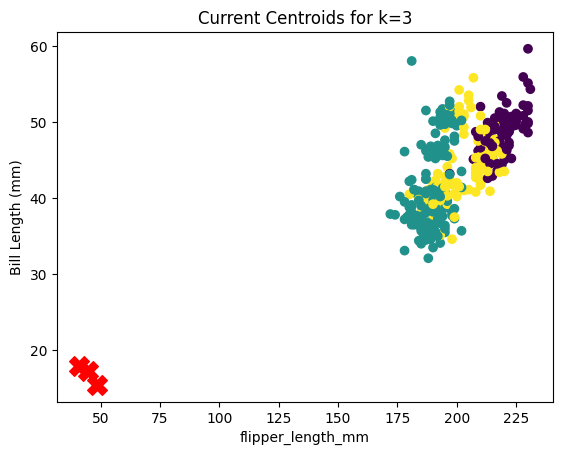

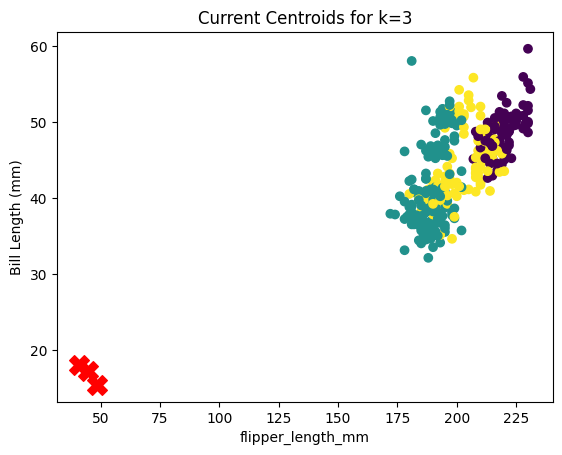

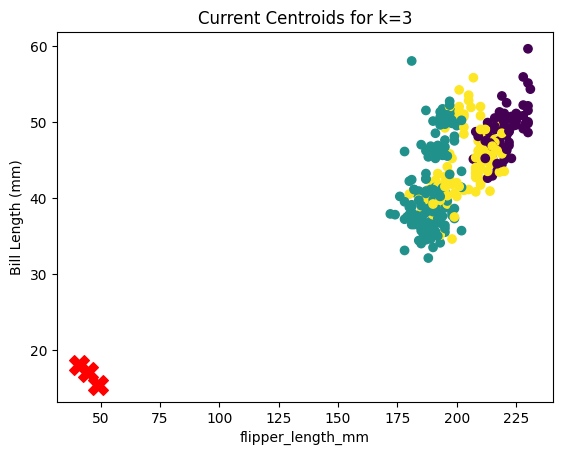

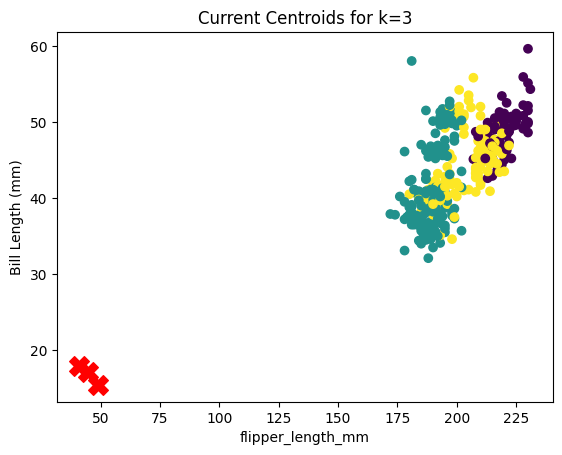

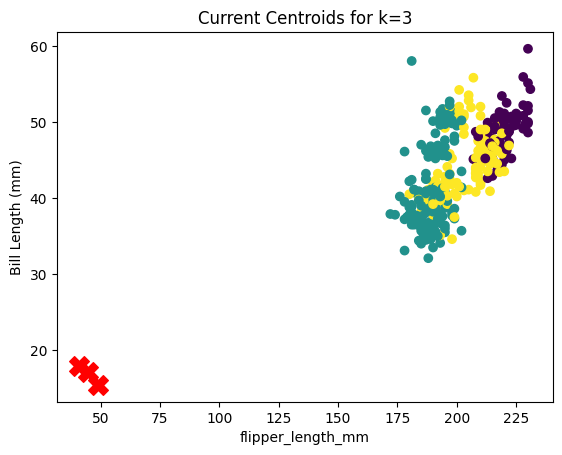

In [72]:
k=3
print(f"Running K-Means with k={k}")
clusters = K_Means(k, penguins)